In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)
import numpy as np
import pandas as pd
from utils.utils import PROJECT_DATA_DIR
import os
from __future__ import print_function
import mxnet as mx
from mxnet import autograd, gluon
import mxnet.ndarray as nd
from time import time

import tarfile
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

# Note we use gpu, how to change it in runtime?
ctx = mx.gpu()

C:\Users\gilbe\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data 

In [2]:
sensor_train = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 
                                        'all_training_400_minisensor_1.csv'), 
                           sep='\s+', header=None)

sensor_test = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 
                                       'all_test_400_minisensor.csv'),
                          sep='\s+', header=None)

In [3]:
sensor_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,-3,3,4,-3,3,4,1,-3,2,0,...,0,0,0,3,0,-4,-2,0,-5,8
1,3,0,0,1,0,0,0,2,0,0,...,-1,0,-7,3,-1,-7,7,-1,-5,7
2,1,-3,7,0,1,4,-3,4,0,-2,...,-4,1,8,-2,1,12,0,4,11,4
3,4,1,-1,3,4,-8,3,4,-1,3,...,0,4,-5,-1,3,6,3,4,7,6
4,0,-4,0,5,0,0,5,0,-5,0,...,0,-4,-4,3,3,0,4,3,1,8


In [4]:
sensor_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200
0,1,-1,-1,0,2,-1,-2,2,1,-2,...,-2,-3,0,0,0,1,0,2,0,8
1,3,6,-13,3,6,-8,3,6,-2,-1,...,-1,7,44,14,7,51,23,11,59,6
2,-1,2,-1,2,0,-1,-4,-3,0,-4,...,-1,0,-1,-1,0,-8,-3,0,-3,5
3,48,18,-57,48,-3,-148,37,-33,-241,29,...,4,0,-17,9,0,-17,6,0,-21,8
4,-2,-2,0,0,-3,1,-3,0,0,3,...,0,0,4,0,-3,6,3,-3,4,8


In [5]:
sensor_train[sensor_train.columns[-1]].unique()

array([ 8,  7,  4,  6, -1,  1,  5,  2,  9,  3,  0], dtype=int64)

In [6]:
sensor_train[sensor_train.columns[-1]].unique()

array([ 8,  7,  4,  6, -1,  1,  5,  2,  9,  3,  0], dtype=int64)

In [7]:
sensor_test[sensor_test.columns[-1]].unique()

array([ 8,  6,  5,  4,  0, -1,  2,  1,  9,  7,  3], dtype=int64)

In [8]:
from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   Imputer,
                                   QuantileTransformer)

In [9]:
ytrain = sensor_train[sensor_train.columns[-1]]
#ytrain.head()
xtrain = sensor_train.drop(sensor_train.columns[-1], axis=1) 

In [10]:
xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,-3,3,4,-3,3,4,1,-3,2,0,...,-1,0,0,0,3,0,-4,-2,0,-5
1,3,0,0,1,0,0,0,2,0,0,...,-8,-1,0,-7,3,-1,-7,7,-1,-5
2,1,-3,7,0,1,4,-3,4,0,-2,...,4,-4,1,8,-2,1,12,0,4,11
3,4,1,-1,3,4,-8,3,4,-1,3,...,-1,0,4,-5,-1,3,6,3,4,7
4,0,-4,0,5,0,0,5,0,-5,0,...,4,0,-4,-4,3,3,0,4,3,1


In [11]:
ytest = sensor_test[sensor_test.columns[-1]]
xtest = sensor_test.drop(sensor_test.columns[-1], axis=1) 

In [12]:
ytrain_sc = ytrain.map(lambda x: 1 if (x == 2 or x == 3) else 0)
ytest_sc = ytest.map(lambda x: 1 if (x == 2 or x == 3) else 0)

In [13]:
print(ytrain_sc.unique())
ytrain_sc.head()


[0 1]


0    0
1    0
2    0
3    0
4    0
Name: 1200, dtype: int64

## Preprocessing

In [14]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91104 entries, 0 to 91103
Columns: 1200 entries, 0 to 1199
dtypes: int64(1200)
memory usage: 834.1 MB


In [15]:
print(xtrain.shape)
xtrain.describe()

(91104, 1200)


,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
count,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,...,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000,91104.000000
mean,-0.148303,-0.084958,1.254369,-0.187906,-0.006333,1.236104,-0.169652,-0.041293,1.176655,-0.134264,...,1.176524,-0.145855,-0.018858,1.112937,-0.092213,-0.039427,1.077790,-0.040437,-0.056682,1.104759
std,27.286271,27.909568,46.855641,27.765273,28.559648,46.999119,28.626503,28.982204,46.765926,28.193874,...,46.367091,27.301695,27.251507,46.007632,27.150623,27.219451,46.120196,26.833842,26.793117,45.991891
min,-1914.000000,-1998.000000,-1160.000000,-1914.000000,-1998.000000,-1160.000000,-2305.000000,-1998.000000,-1160.000000,-2305.000000,...,-1160.000000,-1914.000000,-1998.000000,-1160.000000,-1914.000000,-1998.000000,-1160.000000,-2305.000000,-1998.000000,-950.000000
25%,-2.000000,-2.000000,-4.000000,-2.000000,-2.000000,-4.000000,-2.000000,-2.000000,-4.000000,-2.000000,...,-4.000000,-2.000000,-2.000000,-4.000000,-2.000000,-2.000000,-4.000000,-2.000000,-2.000000,-4.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,2.000000,5.000000,3.000000,2.000000,5.000000,3.000000,2.000000,5.000000,3.000000,...,5.000000,3.000000,2.000000,5.000000,3.000000,2.000000,5.000000,3.000000,2.000000,5.000000
max,542.000000,2001.000000,1169.000000,438.000000,2054.000000,1169.000000,542.000000,2054.000000,1169.000000,542.000000,...,1169.000000,542.000000,2001.000000,1169.000000,542.000000,2054.000000,1169.000000,542.000000,2054.000000,1169.000000


In [16]:
import matplotlib.pyplot as plt

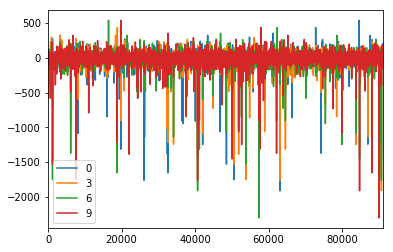

In [17]:
xtrain[xtrain.columns[0:10:3]].plot()
plt.show()

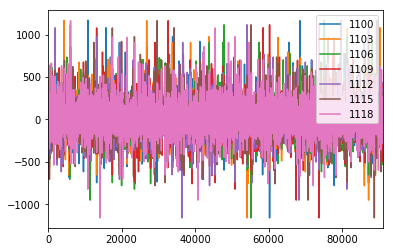

In [18]:
xtrain[xtrain.columns[1100:1120:3]].plot()
plt.show()

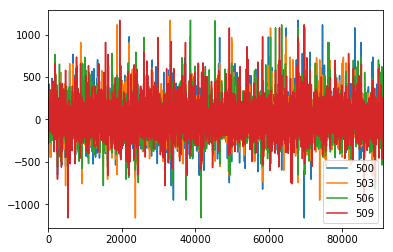

In [19]:
xtrain[xtrain.columns[500:510:3]].plot()
plt.show()

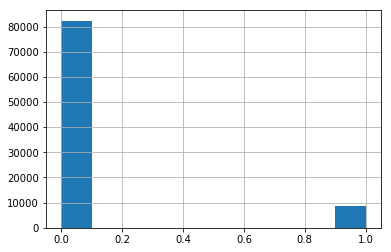

In [ ]:
ytrain_sc.hist()
plt.show()

In [ ]:
ytest_sc.hist()
plt.show()

## Scaling and transforming data

In [ ]:
scaler = StandardScaler()#QuantileTransformer(output_distribution='normal')
xtrain_sc = scaler.fit_transform(xtrain)
xtest_sc = scaler.transform(xtest)

In [ ]:
print(ytrain_sc.shape)
print(xtrain_sc.shape)
type(xtrain_sc)


In [ ]:
plt.plot(xtrain_sc[:,0:10:3])
plt.show()


In [ ]:
plt.plot(xtest_sc[:,0:10:3])
plt.show()

# Transform data to mxnet tensors
TODO:
* make the transformations with mxnet tensors
* use compose with mxnet's DataLoader


In [ ]:
xtrain_mx = mx.nd.array(xtrain_sc, dtype=np.float32)
ytrain_mx = mx.nd.array(ytrain_sc, dtype=np.float32)
#print('Shape of mxnet tensor xtrain:', xtrain_mx.shape)
#print('Shape of mxnet ytrain:', ytrain_mx.shape)


xtest_mx = mx.nd.array(xtest_sc, dtype=np.float32)
ytest_mx = mx.nd.array(ytest_sc, dtype=np.float32)
#print('Shape of mxnet tensor xtest:', xtest_mx.shape)
#print('Shape of mxnet ytest:', ytest_mx.shape)

## Load data in MXNet with DataLoader

In [ ]:
batch_size = 2**9
train_iter = mx.io.NDArrayIter(xtrain_mx, ytrain_mx, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(xtest_mx, ytest_mx, batch_size)


In [ ]:
train_iter

# MXNet model
* Note no activation at the output as this will computed by the loss

In [ ]:
hidden_units = [1200, 500, 75]
num_outputs = 1

net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=hidden_units[0])
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=hidden_units[1])
net = mx.sym.Activation(net, name='relu2', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc3', num_hidden=hidden_units[2])
net = mx.sym.Activation(net, name='relu3', act_type="relu")
net = mx.sym.FullyConnected(net, name='out', num_hidden=num_outputs)
net = mx.sym.LogisticRegressionOutput(net, name='softmax')


In [ ]:
train_iter.reset()
val_iter.reset()
mod = mx.mod.Module(net, context=mx.gpu())
mod.bind(data_shapes=train_iter.provide_data, 
         label_shapes=train_iter.provide_label)

mod.init_params(initializer=mx.init.Xavier())

lr_sch = mx.lr_scheduler.FactorScheduler(step=100, factor=0.9)

mod.init_optimizer(optimizer='sgd', 
                   optimizer_params=(('learning_rate', 0.01), 
                                     ('lr_scheduler', lr_sch)))

train_iter.reset()
mod.fit(train_iter, 
        eval_data=val_iter, 
        optimizer='Adam', 
        optimizer_params={'learning_rate': 0.01},
        eval_metric='acc', 
        num_epoch=20)


In [ ]:
net.list_arguments()

### Good example to add layers

In [ ]:
data = mx.sym.Variable("data")
net = data
n_layer = 5
for i in range(n_layer):
    with mx.name.Prefix("layer{}_".format(i + 1)):
        net = mx.sym.FullyConnected(data=net, name="fc", num_hidden=100)
net.list_arguments()

In [ ]:
a = mx.sym.Variable('a')
b = mx.sym.Variable('b')
c = a + b
(a, b, c)
arg_name = c.list_arguments()
out_name = c.list_outputs()
(arg_name, out_name)

In [ ]:
gpu_device=mx.gpu() # Change this to mx.cpu() in absence of GPUs.

ex_gpu = c.bind(ctx=gpu_device, args={'a' : mx.nd.ones([3,4], gpu_device)*2,
                                      'b' : mx.nd.ones([3,4], gpu_device)*3})
ex_gpu.forward()
ex_gpu.outputs[0].asnumpy()